# AML: Elliptic Dataset
# Classification model
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data

[1] Elliptic, www.elliptic.co.

[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

Description: The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.


In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import os 

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (    roc_auc_score)
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from imblearn.over_sampling import SMOTE

from src.models.evaluate_model import *
from src.models.train_model import * 
# Set random seeds for reproducibility
import random
import torch
random.seed('ROSALIA')
np.random.seed(3)
torch.manual_seed(15)


# Example usage of batch processing
batch_results, batch_metadata = batch_prediction_pipeline(
    'data/large_blockchain_data/',  # Directory with parquet files
    loaded_iso_forest,
    loaded_xgb_model,
    config['threshold'],
    batch_size=50000,
    explain=False  # Set to True for explanations (slower)
)


=== PIPELINE COMPLETE ===


In [2]:
# Load and preprocess data
DATA_PATH = 'data/processed/'
dataset = pd.read_parquet(DATA_PATH + 'df_model.parquet')
dataset = dataset.dropna()
dataset['class_label'] = dataset['class_label'].astype('category')

# Define features
augmented_net_feat = [c for c in dataset.columns if c.startswith('gw_') or c.startswith('gcn_')]
features = augmented_net_feat + [c for c in dataset.columns if c.startswith('neighbors_') or c.startswith('transaction_')]

In [3]:
# Prepare data
X = dataset.loc[:, features]
Y = dataset['class_label']

# Split into labeled and unlabeled
X_all_labeled = X[Y != 'unknown'].copy()
y_all_labeled = Y[Y != 'unknown'].map({'licit': 0, 'illicit': 1})
X_unlabeled = X[Y == 'unknown'].copy()

# Create a stratified split of labeled data: train (60%), validation (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all_labeled, y_all_labeled, test_size=0.2, random_state=42, stratify=y_all_labeled
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data splits:")
print(f"Training: {len(X_train)} samples, {y_train.sum()} illicit ({y_train.mean()*100:.2f}%)")
print(f"Validation: {len(X_val)} samples, {y_val.sum()} illicit ({y_val.mean()*100:.2f}%)")
print(f"Test: {len(X_test)} samples, {y_test.sum()} illicit ({y_test.mean()*100:.2f}%)")
print(f"Unlabeled: {len(X_unlabeled)} samples")


Data splits:
Training: 27938 samples, 2727.0 illicit (9.76%)
Validation: 9313 samples, 909.0 illicit (9.76%)
Test: 9313 samples, 909.0 illicit (9.76%)
Unlabeled: 157205 samples


In [4]:
# === HYPERPARAMETER TUNING ===
# Step 1: Isolation Forest Hyperparameter Tuning
print("\n=== ISOLATION FOREST HYPERPARAMETER TUNING ===")

# Prepare train data for Isolation Forest with focus on licit transactions
licit_train_indices = y_train[y_train == 0].index

# Different illicit sampling rates to test
sampling_rates = [0.05, 0.1, 0.2, 0.3]
contamination_rates = [0.01, 0.02, 0.05, 0.1]

# Grid for Isolation Forest
iforest_grid = {
    'sampling_rate': sampling_rates,
    'contamination': contamination_rates,
    'n_estimators': [100, 500, 1000],
    'max_samples': ['auto', 256, 512],
    'random_state': [42]
}

# Perform grid search for Isolation Forest
best_if_score = -np.inf
best_if_params = None
best_if_model = None

# Use a fraction of validation data for quicker tuning
val_sample_size = min(1000, len(X_val))
X_val_sample = X_val.sample(val_sample_size, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

print("Searching for best Isolation Forest parameters...")
for n_estimators in iforest_grid['n_estimators']:
    for max_samples in iforest_grid['max_samples']:
        for contamination in iforest_grid['contamination']:
            for sampling_rate in iforest_grid['sampling_rate']:
                # Create the train set for this configuration
                illicit_train_indices = y_train[y_train == 1].index
                illicit_sample = np.random.choice(
                    illicit_train_indices,
                    size=int(sampling_rate * len(illicit_train_indices)),
                    replace=False
                )
                train_indices = np.concatenate([licit_train_indices, illicit_sample])
                X_if_train = X_train.loc[train_indices]
                
                # Train Isolation Forest
                iso_forest = IsolationForest(
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    contamination=contamination,
                    random_state=42,
                    n_jobs=-1  # Use all cores
                )
                
                iso_forest.fit(X_if_train)
                
                # Evaluate on validation sample
                raw_scores = iso_forest.decision_function(X_val_sample)
                y_proba = (raw_scores.max() - raw_scores) / (raw_scores.max() - raw_scores.min())
                y_pred = (iso_forest.predict(X_val_sample) == -1).astype(int)
                
                # Calculate AUC as our optimization metric
                auc_score = roc_auc_score(y_val_sample, y_proba)
                
                if auc_score > best_if_score:
                    best_if_score = auc_score
                    best_if_params = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'contamination': contamination,
                        'sampling_rate': sampling_rate
                    }
                    best_if_model = iso_forest

print(f"Best Isolation Forest Parameters: {best_if_params}")
print(f"Best AUC Score: {best_if_score:.4f}")

# Train final Isolation Forest with best parameters
illicit_train_indices = y_train[y_train == 1].index
illicit_sample = np.random.choice(
    illicit_train_indices,
    size=int(best_if_params['sampling_rate'] * len(illicit_train_indices)),
    replace=False
)
train_indices = np.concatenate([licit_train_indices, illicit_sample])
X_if_train = X_train.loc[train_indices]

final_iso_forest = IsolationForest(
    n_estimators=best_if_params['n_estimators'],
    max_samples=best_if_params['max_samples'],
    contamination=best_if_params['contamination'],
    random_state=42,
    n_jobs=-1,
    verbose=1
)
final_iso_forest.fit(X_if_train)

# Generate anomaly scores for all datasets
print("\n=== GENERATING ANOMALY SCORES WITH TUNED MODEL ===")
X_train_with_scores = add_anomaly_scores(X_train, final_iso_forest)
X_val_with_scores = add_anomaly_scores(X_val, final_iso_forest)
X_test_with_scores = add_anomaly_scores(X_test, final_iso_forest)
X_unlabeled_with_scores = add_anomaly_scores(X_unlabeled, final_iso_forest)

# Evaluate Isolation Forest on validation set
print("\n=== EVALUATING TUNED ISOLATION FOREST ===")
if_results_val = evaluate_model(
    final_iso_forest, X_val, y_val, 
    "Isolation Forest (Validation Set)", 
    is_isolation_forest=True
)


=== ISOLATION FOREST HYPERPARAMETER TUNING ===
Searching for best Isolation Forest parameters...
Best Isolation Forest Parameters: {'n_estimators': 100, 'max_samples': 512, 'contamination': 0.01, 'sampling_rate': 0.2}
Best AUC Score: 0.2050

=== GENERATING ANOMALY SCORES WITH TUNED MODEL ===


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



=== EVALUATING TUNED ISOLATION FOREST ===

Isolation Forest (Validation Set) Results (threshold=0.500):
Overall Metrics:
  F1 Score: 0.0020
  Precision: 0.0120
  Recall (Sensitivity): 0.0011
  Specificity: 0.9902
  AUC: 0.2085
  Average Precision: 0.0573

Micro & Macro Averages:
  Micro F1: 0.8937, Precision: 0.8937, Recall: 0.8937
  Macro F1: 0.4729, Precision: 0.4568, Recall: 0.4957

Confusion Matrix:
[[8322   82]
 [ 908    1]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      8404
         1.0       0.01      0.00      0.00       909

    accuracy                           0.89      9313
   macro avg       0.46      0.50      0.47      9313
weighted avg       0.81      0.89      0.85      9313


Illicit Detection Performance:
  Precision (% of flagged transactions that are truly illicit): 0.0120
  Recall (% of illicit transactions successfully caught): 0.0011
  F1 Score: 0.0020


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [5]:
# Step 2: XGBoost Hyperparameter Tuning
print("\n=== XGBOOST HYPERPARAMETER TUNING ===")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_with_scores, y_train)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val_with_scores, label=y_val)

# XGBoost hyperparameter grid
xgb_param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5, 1.0],
    'lambda': [0.1, 1.0, 5.0, 10.0],
    'alpha': [0, 0.1, 1.0, 10.0]
}

# Simplified grid for demonstration (adjust for actual use)
xgb_param_grid_simplified = {
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'eta': [0.05, 0.1],
    'gamma': [0, 1.0]
}

# Randomized search for XGBoost
print("Performing randomized search for XGBoost parameters...")
n_iterations = 20  # Increase for better results
best_score = -np.inf
best_params = None
best_model = None
best_threshold = 0.5

for _ in tqdm(range(n_iterations)):
    # Randomly sample parameters
    params = {
        'max_depth': np.random.choice(xgb_param_grid['max_depth']),
        'min_child_weight': np.random.choice(xgb_param_grid['min_child_weight']),
        'subsample': np.random.choice(xgb_param_grid['subsample']),
        'colsample_bytree': np.random.choice(xgb_param_grid['colsample_bytree']),
        'eta': np.random.choice(xgb_param_grid['eta']),
        'gamma': np.random.choice(xgb_param_grid['gamma']),
        'lambda': np.random.choice(xgb_param_grid['lambda']),
        'alpha': np.random.choice(xgb_param_grid['alpha'])
    }
    
    # Train and evaluate
    cv_results = xgb_cv(params, dtrain, dval)
    
    # Track best model
    if cv_results['f1'] > best_score:
        best_score = cv_results['f1']
        best_params = params
        best_model = cv_results['model']
        best_threshold = cv_results['threshold']

# Report best parameters
print(f"Best XGBoost Parameters: {best_params}")
print(f"Best F1 Score: {best_score:.4f} (threshold: {best_threshold:.4f})")
print(f"Best Iteration: {best_model.best_iteration}")

# Evaluate best XGBoost model on validation set
xgb_results_val = evaluate_model(
    best_model, X_val_with_scores, y_val, 
    "XGBoost (Validation, Optimal Threshold)",
    threshold=best_threshold,
    anomaly_score_col='anomaly_score'
)



=== XGBOOST HYPERPARAMETER TUNING ===
Performing randomized search for XGBoost parameters...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.04s/it]

Best XGBoost Parameters: {'max_depth': np.int64(3), 'min_child_weight': np.int64(1), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.7), 'eta': np.float64(0.2), 'gamma': np.float64(0.1), 'lambda': np.float64(5.0), 'alpha': np.float64(0.1)}
Best F1 Score: 0.9928 (threshold: 0.7276)
Best Iteration: 171

XGBoost (Validation, Optimal Threshold) Results (threshold=0.728):
Overall Metrics:
  F1 Score: 0.9928
  Precision: 0.9945
  Recall (Sensitivity): 0.9912
  Specificity: 0.9994
  AUC: 0.9999
  Average Precision: 0.9988

Micro & Macro Averages:
  Micro F1: 0.9986, Precision: 0.9986, Recall: 0.9986
  Macro F1: 0.9960, Precision: 0.9968, Recall: 0.9953

Confusion Matrix:
[[8399    5]
 [   8  901]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8404
         1.0       0.99      0.99      0.99       909

    accuracy                           1.00      9313
   macro avg       1.00      1.00 


=== SEMI-SUPERVISED LEARNING ===
Found 9977 high-confidence illicit and 139353 high-confidence licit transactions
[0]	train-auc:0.94103	val-auc:0.94163
[100]	train-auc:0.99998	val-auc:0.99964
[170]	train-auc:0.99999	val-auc:0.99972


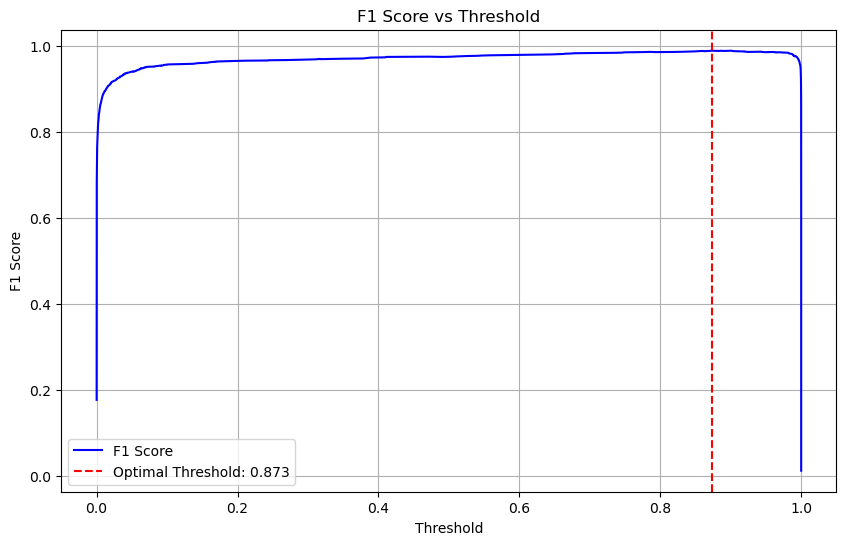

Improved model optimal threshold: 0.8733 (F1: 0.9896)


In [6]:
# Step 3: Semi-supervised learning with unlabeled data
print("\n=== SEMI-SUPERVISED LEARNING ===")
# Use asymmetric thresholds for pseudo-labeling
illicit_threshold = 0.8
licit_threshold = 0.2

# Predict on unlabeled data
dunlabeled = xgb.DMatrix(X_unlabeled_with_scores)
unlabeled_probs = best_model.predict(dunlabeled)

# Find high-confidence predictions
illicit_indices = np.where(unlabeled_probs > illicit_threshold)[0]
licit_indices = np.where(unlabeled_probs < licit_threshold)[0]
print(f"Found {len(illicit_indices)} high-confidence illicit and {len(licit_indices)} high-confidence licit transactions")

# Proceed with semi-supervised learning if we have high-confidence predictions
if len(illicit_indices) + len(licit_indices) > 0:
    # Create pseudo-labels
    pseudo_indices = np.concatenate([illicit_indices, licit_indices])
    pseudo_labels = np.zeros(len(pseudo_indices))
    pseudo_labels[:len(illicit_indices)] = 1  # 1 for illicit
    
    # Add to training data
    X_pseudo = X_unlabeled_with_scores.iloc[pseudo_indices]
    y_pseudo = pd.Series(pseudo_labels, index=X_pseudo.index)
    
    # Combine with original data
    X_combined = pd.concat([X_train_with_scores, X_pseudo])
    y_combined = pd.concat([y_train, y_pseudo])
    
    # Apply SMOTE to the combined data
    X_combined_resampled, y_combined_resampled = smote.fit_resample(X_combined, y_combined)
    
    # Train improved model
    dtrain_combined = xgb.DMatrix(X_combined_resampled, label=y_combined_resampled)
    
    # Use best parameters from tuning
    fixed_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': (y_combined == 0).sum() / (y_combined == 1).sum()
    }
    final_params = {**fixed_params, **best_params}
    
    improved_model = xgb.train(
        final_params,
        dtrain_combined,
        num_boost_round=best_model.best_iteration,  # Use best iteration from tuning
        evals=[(dtrain_combined, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # Update the optimal threshold using validation set
    val_probs_improved = improved_model.predict(dval)
    improved_threshold, improved_f1 = find_optimal_f1_threshold(y_val, val_probs_improved)
    print(f"Improved model optimal threshold: {improved_threshold:.4f} (F1: {improved_f1:.4f})")
    
    # Our final model is the improved model
    final_model = improved_model
    final_threshold = improved_threshold
else:
    print("No high-confidence predictions found. Using initial model.")
    final_model = best_model
    final_threshold = best_threshold


In [7]:
final_threshold

np.float32(0.8733063)

In [8]:
# Step 4: Final Evaluation on Test Set
print("\n=== FINAL EVALUATION ON TEST SET ===")
# Evaluate on test set with final model and threshold
test_results = evaluate_model(
    final_model, X_test_with_scores, y_test,
    "Final Model (Test Set)",
    threshold=final_threshold,
    anomaly_score_col='anomaly_score'
)


=== FINAL EVALUATION ON TEST SET ===

Final Model (Test Set) Results (threshold=0.873):
Overall Metrics:
  F1 Score: 0.9818
  Precision: 0.9856
  Recall (Sensitivity): 0.9780
  Specificity: 0.9985
  AUC: 0.9998
  Average Precision: 0.9986

Micro & Macro Averages:
  Micro F1: 0.9965, Precision: 0.9965, Recall: 0.9965
  Macro F1: 0.9899, Precision: 0.9916, Recall: 0.9882

Confusion Matrix:
[[8391   13]
 [  20  889]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8404
         1.0       0.99      0.98      0.98       909

    accuracy                           1.00      9313
   macro avg       0.99      0.99      0.99      9313
weighted avg       1.00      1.00      1.00      9313


Illicit Detection Performance:
  Precision (% of flagged transactions that are truly illicit): 0.9856
  Recall (% of illicit transactions successfully caught): 0.9780
  F1 Score: 0.9818


In [9]:
# === SAVE MODELS AND PIPELINE ===
print("\n=== SAVING MODELS AND PIPELINE ===")

# Create a directory for models
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save Isolation Forest
with open(f'{model_dir}/isolation_forest.pkl', 'wb') as f:
    pickle.dump(final_iso_forest, f)

# Save XGBoost model
final_model.save_model(f'{model_dir}/xgboost_model.json')

# Save threshold and parameters
with open(f'{model_dir}/model_config.pkl', 'wb') as f:
    pickle.dump({
        'threshold': final_threshold,
        'iso_forest_params': best_if_params,
        'xgboost_params': best_params,
        'features': features
    }, f)

print("Models and configuration saved to 'models' directory")



=== SAVING MODELS AND PIPELINE ===
Models and configuration saved to 'models' directory
